# <font color='#154360'> <center> CUSTOM LOSS FUNCTIONS </center> </font>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)  
3. [Data](#3)
4. [Model](#4)
5. [Without hyperparameters](#5) <br>
    5.1. [Function based](#5.1) <br>
    5.2. [Classed based](#5.2) <br>
6. [With hyperparameters](#6) <br>
    6.1. [Function based](#6.1) <br>
    6.2. [Classed based](#6.2) <br>
7. [Annex](#annex) <br>
    A. [Wrappers](#A) <br>
8. [References](#references)


<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

This notebook demonstrates how to implement custom loss functions in TensorFlow using a few simple examples. Custom loss functions allow you to tailor model optimization to specific problem requirements, beyond standard loss functions like MSE or cross-entropy.  We'll cover both function-based and class-based implementations, showcasing their flexibility and ease of integration into Keras models.

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [44]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
# Set seed for NumPy
np.random.seed(42)

# Set seed for TensorFlow
tf.random.set_seed(42)

<a name="3"></a>
## <font color='blue'> 3. Data </font>

We will generate synthetic data.

In [39]:
# We will generate the equation y = 2x + 3 + noise

# Generating random X values (100 samples, 1 feature)
X = np.random.rand(100, 1)

# Calculating y based on the equation: y = 2X + 3 + noise
noise = np.random.normal(0, 0.1, X.shape[0])  # Adding Gaussian noise
y = 2 * X.sum(axis=1) + 3 #+ noise  # Sum of X features + 3 + noise

# Check a few values
print(X[:5], y[:5])  # Print first 5 samples

[[0.01971054]
 [0.10410858]
 [0.79991609]
 [0.17854466]
 [0.65274611]] [3.03942108 3.20821716 4.59983217 3.35708932 4.30549222]


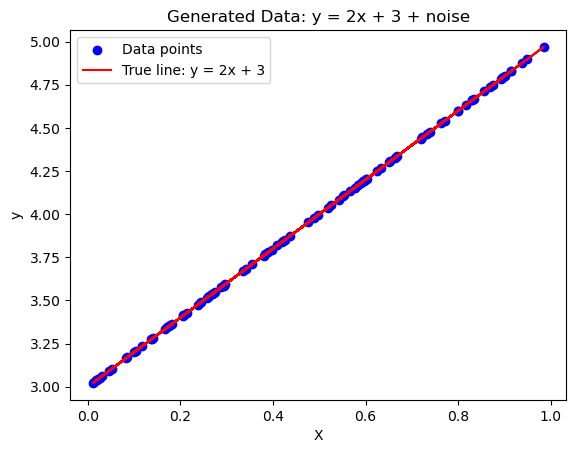

In [45]:
# Plotting the data
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, 2 * X + 3, color='red', label='True line: y = 2x + 3')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated Data: y = 2x + 3 + noise')
plt.legend()
plt.show()

<a name="4"></a>
## <font color='blue'> 4. Model </font>

In [41]:
# model, very simple because our porblem is very simple
def build_model():
    model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
    return model

<a name="5"></a>
## <font color='blue'> 5. Without hyperparameters </font>


<a name="5.1"></a>
### <font color='#1f618d'> 5.1. Function based </font>

Now let's see how we can use a custom loss. We first define a function that accepts the ground truth labels (`y_true`) and model predictions (`y_pred`) as parameters. We then compute and return the loss value in the function definition.

In this example we will implement the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss)

In [12]:
# Custom Huber loss function
def my_huber_loss(y_true, y_pred):
    threshold = 1  # The threshold to distinguish between small and large errors
    error = y_true - y_pred  # Calculate the error between true and predicted values
    
    # Determine if the error is small (within the threshold)
    is_small_error = tf.abs(error) <= threshold
    
    # Loss calculation for small errors: squared loss
    small_error_loss = tf.square(error) / 2
    
    # Loss calculation for large errors: linear loss
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    
    # Return the appropriate loss based on whether the error is small or large
    return tf.where(is_small_error, small_error_loss, big_error_loss)


Using the loss function is as simple as specifying the loss function in the `loss` argument of `model.compile()`.

In [13]:
model_1 = build_model() 

In [14]:
model_1.compile(optimizer='sgd', loss='mse')

model_1.fit(X, y, epochs=500,verbose=0)

print(model_1.predict([10.0]))

1/1 [==============================] - 0s 42ms/step
[[23.799728]]


<a name="5.2"></a>
### <font color='#1f618d'> 5.2. Classed based </font>

In [22]:
# Custom Huber loss class inheriting from tf.keras.losses.Loss
class MyHuberLoss(tf.keras.losses.Loss):
    
    # Initialize the custom loss with a threshold and name
    def __init__(self, threshold=1, name="my_huber_loss"):
        super().__init__(name=name) # Initialize the parent class with the given name
        self.threshold = threshold # Set the threshold for small and large errors

    # Compute the loss given true and predicted values
    def call(self, y_true, y_pred):
        error = y_true - y_pred # Calculate the error between true and predicted values
        
        # Determine if the error is small (within the threshold)
        is_small_error = tf.abs(error) <= self.threshold
        
        # Loss calculation for small errors: squared loss
        small_error_loss = tf.square(error) / 2
        
        # Loss calculation for large errors: linear loss
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        
        # Return the appropriate loss based on whether the error is small or large
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [23]:
model_2 = build_model()

In [24]:
model_2.compile(optimizer='sgd', loss=my_huber_loss)

model_2.fit(X, y, epochs=500,verbose=0)

print(model.predict([10.0]))

1/1 [==============================] - 0s 25ms/step
[[20.271065]]


<a name="6"></a>
## <font color='blue'> 6. With hyperparameters </font>

<a name="6.1"></a>
### <font color='#1f618d'> 6.1. Function based </font>

The `loss` argument in `model.compile()` only accepts functions that accepts two parameters: the ground truth (`y_true`) and the model predictions (`y_pred`). If we want to include a hyperparameter that we can tune, then we can define a wrapper function that accepts this hyperparameter.

In [29]:
# wrapper function that accepts the hyperparameter
def my_huber_loss_with_threshold(threshold):
  
    # function that accepts the ground truth and predictions
    def my_huber_loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
        
        return tf.where(is_small_error, small_error_loss, big_error_loss) 

    # return the inner function tuned by the hyperparameter
    return my_huber_loss

We can now specify the `loss` as the wrapper function above. Notice that we can now set the `threshold` value. 

In [34]:
model_3 = build_model()

model_3.compile(optimizer='sgd', 
              loss=my_huber_loss_with_threshold(threshold=1.2))

model_3.fit(X, y, epochs=500,verbose=0)

print(model_3.predict([10.0]))

1/1 [==============================] - 0s 41ms/step
[[19.442213]]


Next, we can try different threshold values and see what results we get.

In [35]:
# vary the threshold

thresholds = [0.8, 1.2, 1.6]

for t in thresholds:
    # Build a new model for each threshold value
    model = build_model()
    
    # Compile the model with the custom loss function, passing the threshold as an argument
    model.compile(optimizer='sgd', 
                  loss=my_huber_loss_with_threshold(threshold=t))
    
    # Train the model
    model.fit(X, y, epochs=100, verbose=0)
    
    # Print prediction for input value 10.0
    print(model.predict([10.0]))


1/1 [==============================] - 0s 41ms/step
[[9.464515]]
1/1 [==============================] - 0s 41ms/step
[[12.66923]]
1/1 [==============================] - 0s 42ms/step
[[10.611371]]


<a name="6.2"></a>
### <font color='#1f618d'> 6.2. Classed based </font>

In [36]:
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss):
  
    # initialize instance attributes
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold

    # compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [37]:
model_5 = build_model()

In [38]:
model_5.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1.2))

model_5.fit(X, y, epochs=500,verbose=0)

print(model_5.predict([10.0]))

1/1 [==============================] - 0s 41ms/step
[[18.064152]]


<a name="annex"> </a>
## <font color='blue'> 7. Annex </font>

<a name="A"></a>
### <font color='#1f618d'> A. Wrappers </font>

A wrapper in Python is a function or a class that "wraps" another function or object to modify or extend its behavior. Wrappers are commonly used to add extra functionality to an existing function or class without changing its original code. This is often done using decorators or other design patterns.

<b> Why do you need it? </b>

- Code Reusability: Wrappers allow you to reuse existing functions or classes while adding new functionality, such as logging, error handling, or timing, without modifying the original code.

- Separation of Concerns: Wrapping lets you separate concerns like validation, logging, or authentication from the core functionality. This keeps your code clean and modular.

- Cross-Cutting Concerns: Wrappers help in handling concerns that affect multiple parts of a program, like logging, caching, or performance monitoring, without duplicating code.

- Improved Readability: By wrapping a function, you can abstract complex behavior into a smaller, easy-to-understand block.

<b> Example: </b> Using a Wrapper with a Decorator

A common way to implement a wrapper is with decorators, which are a type of wrapper in Python. Here’s an example:

In [46]:
# A simple wrapper function (decorator) to add logging
def log_wrapper(func):
    def wrapper(*args, **kwargs):
        print(f"Calling {func.__name__} with arguments {args} and {kwargs}")
        result = func(*args, **kwargs)
        print(f"{func.__name__} returned {result}")
        return result
    return wrapper

# Using the decorator as a wrapper
@log_wrapper
def add(a, b):
    return a + b

# Calling the function will now include logging
add(2, 3)

Calling add with arguments (2, 3) and {}
add returned 5


5

In this example, the log_wrapper is a decorator that wraps the add function to log information before and after it is called, without changing the actual logic of add.

In TensorFlow, wrappers are often used in custom loss functions to modify or extend the behavior of the loss function without changing its core implementation. Wrappers in custom loss functions can be used for purposes like:
- Parameter tuning.
- Applying custom behaviors.
- Logging information during the loss calculation process

<a name="references"> </a>
## <font color='blue'> 8. References </font>

[TensorFlow Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)


